In [ ]:
pip install pyspark

     |████████████████████████████████| 204.2MB 60kB/s 
     |████████████████████████████████| 204kB 47.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=f2c2c64e1be7872eee99c5b4738d78e4568e6318452c48e08c46c8138f18a78b
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression

In [ ]:
spark=SparkSession.builder.appName('hyundai').getOrCreate()

In [ ]:
data=spark.read.csv('/content/sample_data/cruise_ship_info.csv',inferSchema=True,header=True)

In [ ]:
data.head(5)

[Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55),
 Row(Ship_name='Quest', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55),
 Row(Ship_name='Celebration', Cruise_line='Carnival', Age=26, Tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7),
 Row(Ship_name='Conquest', Cruise_line='Carnival', Age=11, Tonnage=110.0, passengers=29.74, length=9.53, cabins=14.88, passenger_density=36.99, crew=19.1),
 Row(Ship_name='Destiny', Cruise_line='Carnival', Age=17, Tonnage=101.353, passengers=26.42, length=8.92, cabins=13.21, passenger_density=38.36, crew=10.0)]

In [ ]:
data.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [ ]:
import numpy as np

In [ ]:
data.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
data.groupBy('Cruise_line').count().show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|            Costa|   11|
|              P&O|    6|
|           Cunard|    3|
|Regent_Seven_Seas|    5|
|              MSC|    8|
|         Carnival|   22|
|          Crystal|    2|
|           Orient|    1|
|         Princess|   17|
|        Silversea|    4|
|         Seabourn|    3|
| Holland_American|   14|
|         Windstar|    3|
|           Disney|    2|
|        Norwegian|   13|
|          Oceania|    3|
|          Azamara|    2|
|        Celebrity|   10|
|             Star|    6|
|  Royal_Caribbean|   23|
+-----------------+-----+



In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
indexer=StringIndexer(inputCol='Cruise_line',outputCol='cruise_cat')
indexed=indexer.fit(data).transform(data)
indexed.head(5)

[Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, cruise_cat=16.0),
 Row(Ship_name='Quest', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, cruise_cat=16.0),
 Row(Ship_name='Celebration', Cruise_line='Carnival', Age=26, Tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7, cruise_cat=1.0),
 Row(Ship_name='Conquest', Cruise_line='Carnival', Age=11, Tonnage=110.0, passengers=29.74, length=9.53, cabins=14.88, passenger_density=36.99, crew=19.1, cruise_cat=1.0),
 Row(Ship_name='Destiny', Cruise_line='Carnival', Age=17, Tonnage=101.353, passengers=26.42, length=8.92, cabins=13.21, passenger_density=38.36, crew=10.0, cruise_cat=1.0)]

In [ ]:
assembler=VectorAssembler(inputCols=['Age','Tonnage','passengers','length','cabins','passenger_density','cruise_cat'],
                          outputCol='features')

In [ ]:
output=assembler.transform(indexed)

In [ ]:
output.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- cruise_cat: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
output.head()

Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, cruise_cat=16.0, features=DenseVector([6.0, 30.277, 6.94, 5.94, 3.55, 42.64, 16.0]))

In [ ]:
final_data=output.select('features','crew')

In [ ]:
train_data,test_data=final_data.randomSplit([0.7,0.3])

In [ ]:
train_data.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|               103|
|   mean| 7.750582524271855|
| stddev|3.6515365622134737|
|    min|              0.59|
|    max|              21.0|
+-------+------------------+



In [ ]:
test_data.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|                55|
|   mean| 7.875818181818183|
| stddev|3.2388896650899133|
|    min|               1.6|
|    max|              13.6|
+-------+------------------+



In [ ]:
lr_model=LinearRegression(labelCol='crew')

In [ ]:
model=lr_model.fit(train_data)

In [ ]:
results=model.evaluate(test_data)

In [ ]:
results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|  0.2070154085762521|
| -1.5329080522938252|
| 0.21794647112545107|
| -0.5769157900185995|
| -1.2113884266417205|
|-0.44161592119484006|
| -0.5418466401000597|
| -0.5935565839945962|
| -0.5803146867986744|
| -0.5308743086381558|
|  1.0418410366875417|
|  1.0418410366875417|
|-0.23690524952269598|
| -0.3391814999081806|
| -0.3241540417698143|
| -0.1854541400832641|
| 0.25821298214098665|
|-0.17038612605628067|
|-0.21265174168822654|
|  0.2574428889695213|
+--------------------+
only showing top 20 rows



In [ ]:
results.rootMeanSquaredError

0.9443005482204244

In [ ]:
results.r2

0.9134240818820676

In [ ]:
from pyspark.sql.functions import corr

In [ ]:
data.corr('crew','passengers')
#checking correlation between impurt variable and target 

0.9152341306065384

In [ ]:
data.corr('crew','cabins')

0.9508226063578497

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
df=pd.read_csv('/content/sample_data/cruise_ship_info.csv')

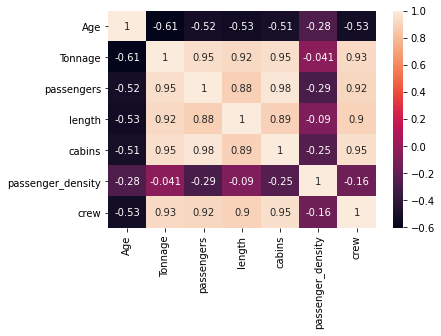

In [ ]:
sns.heatmap(df.corr(),annot=True)

In [ ]:
unlabeled_data=test_data.select('features')

In [ ]:
unlabeled_data.show()

+--------------------+
|            features|
+--------------------+
|[5.0,115.0,35.74,...|
|[5.0,160.0,36.34,...|
|[6.0,110.23899999...|
|[6.0,112.0,38.0,9...|
|[7.0,89.6,25.5,9....|
|[7.0,158.0,43.7,1...|
|[8.0,110.0,29.74,...|
|[9.0,90.09,25.01,...|
|[9.0,105.0,27.2,8...|
|[9.0,110.0,29.74,...|
|[9.0,113.0,26.74,...|
|[9.0,113.0,26.74,...|
|[10.0,68.0,10.8,7...|
|[10.0,81.76899999...|
|[10.0,90.09,25.01...|
|[10.0,91.62700000...|
|[11.0,58.6,15.66,...|
|[11.0,91.62700000...|
|[12.0,25.0,3.88,5...|
|[12.0,42.0,14.8,7...|
+--------------------+
only showing top 20 rows



In [ ]:
predictions=model.transform(unlabeled_data)

In [ ]:
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[5.0,115.0,35.74,...|11.992984591423747|
|[5.0,160.0,36.34,...|15.132908052293825|
|[6.0,110.23899999...|11.282053528874549|
|[6.0,112.0,38.0,9...|  11.4769157900186|
|[7.0,89.6,25.5,9....| 11.08138842664172|
|[7.0,158.0,43.7,1...| 14.04161592119484|
|[8.0,110.0,29.74,...| 12.14184664010006|
|[9.0,90.09,25.01,...| 9.283556583994596|
|[9.0,105.0,27.2,8...|11.260314686798674|
|[9.0,110.0,29.74,...|12.130874308638155|
|[9.0,113.0,26.74,...|11.338158963312459|
|[9.0,113.0,26.74,...|11.338158963312459|
|[10.0,68.0,10.8,7...| 6.596905249522696|
|[10.0,81.76899999...|  8.75918149990818|
|[10.0,90.09,25.01...| 8.904154041769814|
|[10.0,91.62700000...| 9.185454140083264|
|[11.0,58.6,15.66,...| 7.341787017859013|
|[11.0,91.62700000...|  9.17038612605628|
|[12.0,25.0,3.88,5...|3.0826517416882266|
|[12.0,42.0,14.8,7...|6.5425571110304785|
+--------------------+------------

In [ ]:
test_data.show()

+--------------------+-----+
|            features| crew|
+--------------------+-----+
|[5.0,115.0,35.74,...| 12.2|
|[5.0,160.0,36.34,...| 13.6|
|[6.0,110.23899999...| 11.5|
|[6.0,112.0,38.0,9...| 10.9|
|[7.0,89.6,25.5,9....| 9.87|
|[7.0,158.0,43.7,1...| 13.6|
|[8.0,110.0,29.74,...| 11.6|
|[9.0,90.09,25.01,...| 8.69|
|[9.0,105.0,27.2,8...|10.68|
|[9.0,110.0,29.74,...| 11.6|
|[9.0,113.0,26.74,...|12.38|
|[9.0,113.0,26.74,...|12.38|
|[10.0,68.0,10.8,7...| 6.36|
|[10.0,81.76899999...| 8.42|
|[10.0,90.09,25.01...| 8.58|
|[10.0,91.62700000...|  9.0|
|[11.0,58.6,15.66,...|  7.6|
|[11.0,91.62700000...|  9.0|
|[12.0,25.0,3.88,5...| 2.87|
|[12.0,42.0,14.8,7...|  6.8|
+--------------------+-----+
only showing top 20 rows



In [ ]:
final_data.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+

